In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, ttest_ind

# File paths
property_values_path = "/Users/amanagrawal/Desktop/Data Sci 2025/property values by neighborhood.csv"
neighborhoods_path = "//Users/amanagrawal/Desktop/Data Sci 2025/usneighborhoods.csv"
parks_geojson_path = "/Users/amanagrawal/Desktop/Data Sci 2025/USA_Parks.geojson"
merged_output_path = "/Users/amanagrawal/Desktop/Data Sci 2025/merged_property_values.geojson"
# Step 1: Load datasets
print("Loading datasets...")
property_values_data = pd.read_csv(property_values_path)
neighborhoods_data = pd.read_csv(neighborhoods_path)

largest_cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'Jacksonville', 'Austin', 'Fort Worth', 'San Jose', 'Columbus', 'Charlotte', 'Indianapolis', 'San Francisco', 'Seattle', 'Denver', 'Oklahoma City', 'Nashville', 'Washington', 'El Paso', 'Las Vegas', 'Boston', 'Detroit', 'Portland', 'Louisville', 'Memphis', 'Baltimore', 'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Sacramento', 'Mesa', 'Atlanta', 'Kansas City', 'Colorado Springs', 'Omaha', 'Raleigh', 'Miami', 'Virginia Beach', 'Long Beach', 'Oakland', 'Minneapolis', 'Bakersfield', 'Tulsa', 'Tampa', 'Arlington', 'Wichita', 'Aurora', 'New Orleans', 'Cleveland', 'Honolulu', 'Anaheim', 'Henderson', 'Orlando', 'Lexington', 'Stockton', 'Riverside', 'Corpus Christi', 'Irvine', 'Cincinnati', 'Santa Ana', 'Newark', 'Saint Paul', 'Pittsburgh', 'Greensboro', 'Durham', 'Lincoln', 'Jersey City', 'Plano', 'Anchorage', 'North Las Vegas', 'St. Louis', 'Madison', 'Chandler', 'Gilbert', 'Reno', 'Buffalo', 'Chula Vista', 'Fort Wayne', 'Lubbock', 'Toledo', 'St. Petersburg', 'Laredo', 'Irving', 'Chesapeake', 'Glendale', 'Winston-Salem', 'Port St. Lucie', 'Scottsdale', 'Garland', 'Boise', 'Norfolk', 'Spokane', 'Richmond', 'Fremont', 'Huntsville']
#3 largest cities in US
largest_cities = largest_cities[:100]

neighborhoods_data = neighborhoods_data[neighborhoods_data['city_name'].isin(largest_cities)]

parks_gdf = gpd.read_file(parks_geojson_path)

# Step 2: Convert neighborhoods to GeoDataFrame
print("Converting neighborhoods to GeoDataFrame...")
neighborhoods_data['geometry'] = neighborhoods_data.apply(
    lambda row: Point(row['lng'], row['lat']), axis=1
)
neighborhoods_gdf = gpd.GeoDataFrame(neighborhoods_data, geometry='geometry', crs="EPSG:4326")

# Step 3: Prepare property values dataset
print("Preparing property values dataset...")
property_values_data.rename(columns={'RegionName': 'neighborhood', 'Prop_Values': 'Property_Value'}, inplace=True)

# Step 4: Merge neighborhoods with property values
print("Merging neighborhoods with property values...")
merged_gdf = neighborhoods_gdf.merge(property_values_data, on='neighborhood', how='inner')

# Step 5: Use centroids for park polygons
print("Converting park polygons to centroids...")
parks_gdf['geometry'] = parks_gdf.geometry.centroid
parks_gdf = parks_gdf.set_geometry('geometry')

# Step 6: Reproject to Cartesian coordinates for distance calculations
print("Reprojecting to Cartesian coordinates...")
merged_gdf = merged_gdf.to_crs(epsg=3395)
parks_gdf = parks_gdf.to_crs(epsg=3395)

# Step 7: Calculate nearest park distances
print("Calculating nearest park distances...")
property_coords = np.array(list(merged_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
park_coords = np.array(list(parks_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
park_tree = cKDTree(park_coords)
distances, _ = park_tree.query(property_coords)
merged_gdf['nearest_park_distance'] = distances

# Step 8: Reproject back to WGS84
print("Reprojecting back to WGS84...")
merged_gdf = merged_gdf.to_crs(epsg=4326)

# Step 9: Save the updated GeoDataFrame
print("Saving merged GeoDataFrame...")
merged_gdf.to_file(merged_output_path, driver='GeoJSON')
print(f"Merged GeoDataFrame with park proximity saved to: {merged_output_path}")


Loading datasets...
Converting neighborhoods to GeoDataFrame...
Preparing property values dataset...
Merging neighborhoods with property values...
Converting park polygons to centroids...
Reprojecting to Cartesian coordinates...
Calculating nearest park distances...


/var/folders/16/x8rlyb_s7913cc45kvffjkdc0000gn/T/ipykernel_81598/1408352259.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parks_gdf['geometry'] = parks_gdf.geometry.centroid


Reprojecting back to WGS84...
Saving merged GeoDataFrame...
Merged GeoDataFrame with park proximity saved to: /Users/amanagrawal/Desktop/Data Sci 2025/merged_property_values.geojson


Analyzing differences across multiple cutoffs...
Visualizing differences across cutoff points...


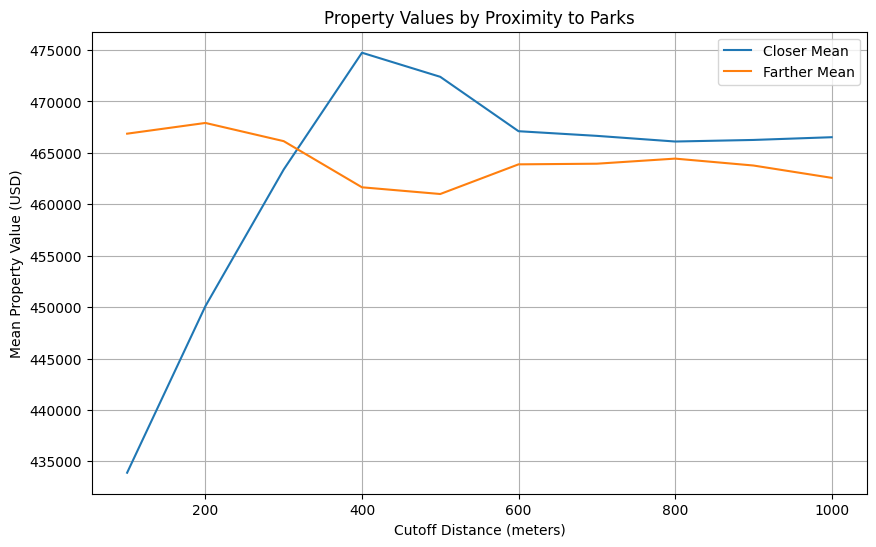

In [4]:

# Step 10: Create subgroups and analyze differences
print("Analyzing differences across multiple cutoffs...")

# TODO: Define cutoff points that work well
cutoff_points = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Cutoff distances in meters
analysis_results = []

for cutoff in cutoff_points:
    # Create subgroups
    merged_gdf['Proximity_Group'] = np.where(merged_gdf['nearest_park_distance'] <= cutoff, 'Closer', 'Farther')
    
    # Calculate means
    closer_mean = merged_gdf[merged_gdf['Proximity_Group'] == 'Closer']['Property_Value'].mean()
    farther_mean = merged_gdf[merged_gdf['Proximity_Group'] == 'Farther']['Property_Value'].mean()
    
    # Perform t-test
    closer_values = merged_gdf[merged_gdf['Proximity_Group'] == 'Closer']['Property_Value']
    farther_values = merged_gdf[merged_gdf['Proximity_Group'] == 'Farther']['Property_Value']
    t_stat, p_value = ttest_ind(closer_values, farther_values, nan_policy='omit')
    
    # Store results
    analysis_results.append({
        'Cutoff (meters)': cutoff,
        'Closer Mean': closer_mean,
        'Farther Mean': farther_mean,
        'T-Statistic': t_stat,
        'P-Value': p_value
    })

# Convert results to DataFrame
analysis_df = pd.DataFrame(analysis_results)

# Step 11: Visualization of differences
print("Visualizing differences across cutoff points...")
plt.figure(figsize=(10, 6))
plt.plot(analysis_df['Cutoff (meters)'], analysis_df['Closer Mean'], label='Closer Mean')
plt.plot(analysis_df['Cutoff (meters)'], analysis_df['Farther Mean'], label='Farther Mean')
plt.xlabel('Cutoff Distance (meters)')
plt.ylabel('Mean Property Value (USD)')
plt.title('Property Values by Proximity to Parks')

plt.legend()
plt.grid(True)
plt.show()



Cutoff point where park proximity increases property values the most:
Cutoff (meters)       400.000000
Closer Mean        474742.563562
Farther Mean       461655.560220
Mean Difference     13087.003341
T-Statistic             1.370891
P-Value                 0.170448
Name: 3, dtype: float64


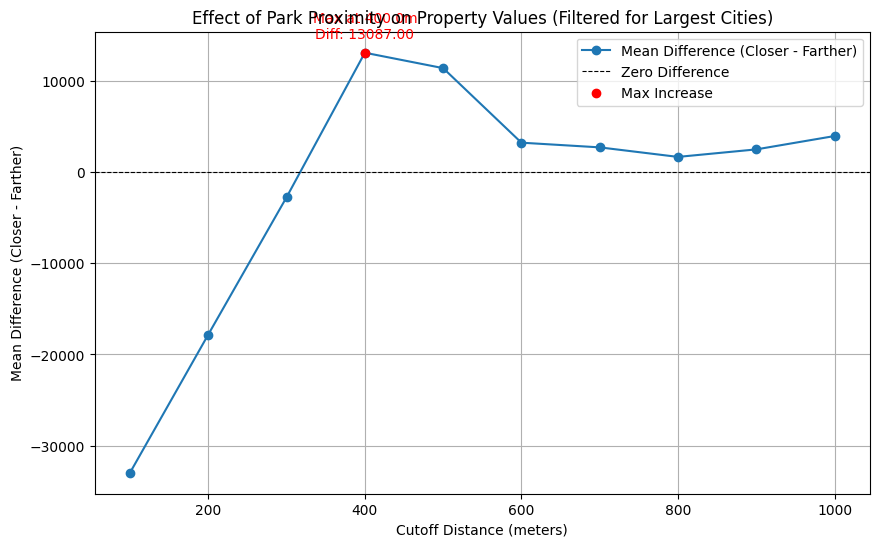

In [5]:
analysis_results = []

for cutoff in cutoff_points:
    merged_gdf['Proximity_Group'] = np.where(merged_gdf['nearest_park_distance'] <= cutoff, 'Closer', 'Farther')
    
    closer_group = merged_gdf[merged_gdf['Proximity_Group'] == 'Closer']['Property_Value']
    farther_group = merged_gdf[merged_gdf['Proximity_Group'] == 'Farther']['Property_Value']
    
    # Calculate means
    closer_mean = closer_group.mean()
    farther_mean = farther_group.mean()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(closer_group, farther_group, nan_policy='omit')
    
    # Calculate mean difference
    mean_difference = closer_mean - farther_mean
    
    # Store the results
    analysis_results.append({
        'Cutoff (meters)': cutoff,
        'Closer Mean': closer_mean,
        'Farther Mean': farther_mean,
        'Mean Difference': mean_difference,
        'T-Statistic': t_stat,
        'P-Value': p_value
    })

# Convert results to DataFrame
analysis_df = pd.DataFrame(analysis_results)
# Step 10: Identify the cutoff point with the greatest significant increase
significance_threshold = 0.2
significant_df = analysis_df[analysis_df['P-Value'] < significance_threshold]

if (not significant_df.empty) and (significant_df['Mean Difference'] > 0).any():
    max_difference_row = significant_df.loc[significant_df['Mean Difference'].idxmax()]
    print("Cutoff point where park proximity increases property values the most:")
    print(max_difference_row)

    # Plot the results with the significant point highlighted
    plt.figure(figsize=(10, 6))
    plt.plot(analysis_df['Cutoff (meters)'], analysis_df['Mean Difference'], label='Mean Difference (Closer - Farther)', marker='o')
    
    # Ensure the zero line is at y=0 for correct interpretation
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Zero Difference')

    # Highlight the point of maximum increase
    plt.scatter(max_difference_row['Cutoff (meters)'], max_difference_row['Mean Difference'], color='red', label='Max Increase', zorder=5)
    plt.annotate(f"Max at {max_difference_row['Cutoff (meters)']}m\nDiff: {max_difference_row['Mean Difference']:.2f}",
                 (max_difference_row['Cutoff (meters)'], max_difference_row['Mean Difference']),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    # Add labels and legend
    plt.xlabel('Cutoff Distance (meters)')
    plt.ylabel('Mean Difference (Closer - Farther)')
    plt.title('Effect of Park Proximity on Property Values (Filtered for Largest Cities)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No statistically significant cutoff points found (P-Value < 0.05).")

Mean property value within 500 meters of a park: $474742.56
Mean property value greater than 500 meters from a park: $461116.27
T-statistic: 1.31
P-value: 0.19
mean difference: 13626.29


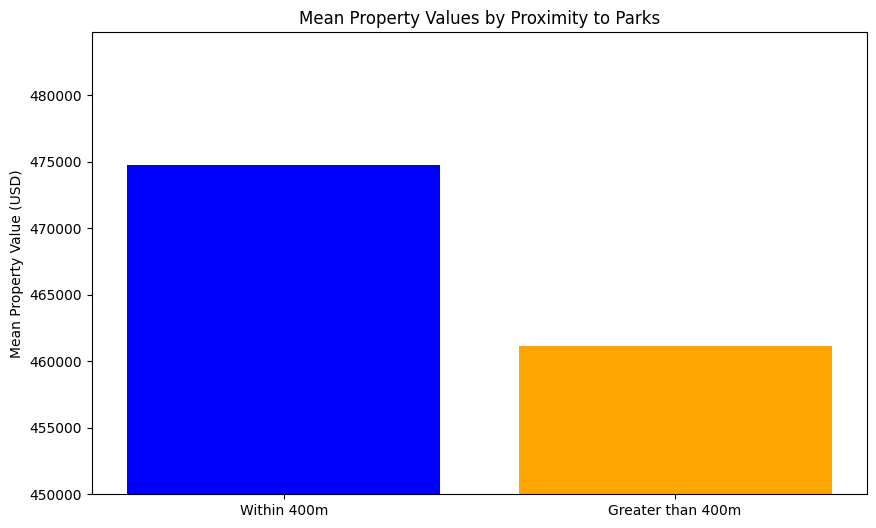

In [7]:
# split into two bins, within 500 meters and greater than 400 meters
close = merged_gdf[merged_gdf['nearest_park_distance'] <= 400]
far = merged_gdf[merged_gdf['nearest_park_distance'] > 400]
far = far[far['nearest_park_distance'] <= 1000]


close_mean = close['Property_Value'].mean()
far_mean = far['Property_Value'].mean()

# calculate t-test
t_stat, p_value = ttest_ind(close['Property_Value'], far['Property_Value'], nan_policy='omit')
# print results
print(f"Mean property value within 500 meters of a park: ${close_mean:.2f}")
print(f"Mean property value greater than 500 meters from a park: ${far_mean:.2f}")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.2f}")
print(f"mean difference: {close_mean - far_mean:.2f}")



# Plot the distribution with y-axis starting at 400,000
plt.figure(figsize=(10, 6))
plt.bar(['Within 400m', 'Greater than 400m'], [close_mean, far_mean], color=['blue', 'orange'])
plt.ylim(450000, max(close_mean, far_mean) + 10000)  # Set y-axis to start at 400,000
plt.ylabel('Mean Property Value (USD)')
plt.title('Mean Property Values by Proximity to Parks')
plt.show()
